# Sentiment classification with English Twitter Datasets

## Importing Libraries

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline

## 1 ) Loading Datasets

In [2]:
df1 = pd.read_csv('tweets_sqgames.csv')
df1 = df1.loc[:, ['text', 'sentiment']]
label_mapping = {"Positive": 1, "Negative":0}
df1 = df1[df1.sentiment != "Neutral"]
df1["sentiment"] = df1["sentiment"].map(label_mapping)

In [3]:
df2 = pd.read_csv('Tweets.csv')
df2 = df2.loc[:, ['text', 'airline_sentiment']]
df2 = df2.rename(columns = {"airline_sentiment":"sentiment"})
label_mapping = {"positive": 1, "negative":0}
df2 = df2[df2.sentiment != "neutral"]
df2["sentiment"] = df2["sentiment"].map(label_mapping)

In [4]:
df3 = pd.read_csv('apple-twitter-sentiment-texts.csv')
label_mapping = {1: 1, -1:0}
df3 = df3[df3.sentiment != 0]
df3["sentiment"] = df3["sentiment"].map(label_mapping)

In [5]:
df4 = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv', encoding="Latin-1")
label_mapping = {"5": 1, "1":0}
df4 = df4[df4.sentiment != "3"]
df4 = df4[df4.sentiment != "not_relevant"]
df4["sentiment"] = df4["sentiment"].map(label_mapping)

In [6]:
df5 = pd.read_csv('Reddit_Data.csv')
df5 = df5.rename(columns = {"clean_comment":"text", "category":"sentiment"})
label_mapping = {1: 1, -1:0}
df5 = df5[df5.sentiment != 0]
df5["sentiment"] = df5["sentiment"].map(label_mapping)

In [7]:
frames = [df1, df2, df3, df4, df5]
merged_df = pd.concat(frames)

In [8]:
from sklearn.model_selection import train_test_split
X = merged_df.text.values
y = merged_df.sentiment.values

In [9]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

## 3 ) Deep Learning Approach

In [10]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


In [11]:
!pip install transformers

In [12]:
from transformers import RobertaTokenizer, RobertaModel

In [13]:
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [14]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """

    # Normalize unicode encoding
    text = unicodedata.normalize('NFC', text)
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    #Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '<URL>', text)


    return text

In [15]:
def remove_emojis(sent):
    text =  emoji.demojize(sent)
    text= re.sub(r'(:[!_\-\w]+:)', '', text)
    return text
    
def text_preprocessing_no_emojis(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
  
    # Remove emojis
    text = remove_emojis(text)

    return text_preprocessing(text)

In [16]:
!pip install emoji

In [17]:
import emoji
import unicodedata
def preprocessing_for_bert(data, version="mini", text_preprocessing_fn = text_preprocessing):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")# if version == "mini" else RobertaTokenizer.from_pretrained("asafaya/bert-base-arabic")

    # For every sentence...
    for i,sent in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_fn(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [18]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

Original:  When life hits and the same time poverty strikes you
Gong Yoo : Lets play a game 
#SquidGame #Netflix https://t.co/Cx7ifmZ8cN
Token IDs:  [0, 1779, 301, 2323, 8, 5, 276, 86, 5263, 5315, 47, 36135, 854, 3036, 4832, 40702, 310, 10, 177, 849, 38378, 808, 20178, 849, 29675, 1205, 640, 90, 4, 876, 73, 347, 1178, 406, 1594, 119, 1301, 398, 438, 487, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [20]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False, version="mini"):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in = 768
        H, D_out = 50, 2

        # Instantiate BERT model
        self.roberta = RobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.1),
            #nn.Linear(768, D_in),
            #nn.Tanh(),
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.roberta(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 7.82 ms, sys: 14 µs, total: 7.84 ms
Wall time: 7.51 ms


In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.optim import SparseAdam, Adam
def initialize_model(epochs=4, version="base"):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False, version=version)
    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(params=list(bert_classifier.parameters()),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [22]:
import random
import time
import torch
import torch.nn as nn

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

       

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [23]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.578079   |     -      |     -     |   29.87  
   1    |   40    |   0.585208   |     -      |     -     |   28.50  
   1    |   60    |   0.552128   |     -      |     -     |   28.50  
   1    |   80    |   0.519892   |     -      |     -     |   28.75  
   1    |   100   |   0.464720   |     -      |     -     |   28.73  
   1    |   120   |   0.485911   |     -      |     -     |   28.76  
   1    |   140   |   0.456612   |     -      |     -     |   28.73  
   1    |   160   |   0.436678   |     -      |     -     |   28.77  
   1    |   180   |   0.490235   |     -      |     -     |   28.79  
   1    |   200   |   0.405700   |     -      |     -     |   28.63  
   1    |   220   |   0.372858   |     -      |     -     |   28.64  
   1    |   240   |   0.347105   |     -      |     -     |   28.74  


In [24]:
import pickle
filename = 'trained-twitter-roberta-base-sentiment.sav'
pickle.dump(bert_classifier, open(filename, 'wb'))

In [25]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [26]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, f1_score

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    #Get Precision and Recall over the test set
    precision  = precision_score(y_true, y_pred, average='binary')
    print(f'Precision: {precision*100:.2f}%')
    recall = recall_score(y_true, y_pred, average='binary')
    print(f'Recall: {recall*100:.2f}%')

    f1 = f1_score(y_true, y_pred)

    
    # Plot ROC AUC
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('Distilbert-base-GRU: f1=%.3f ' % (f1))
    # plot the precision-recall curves
    baseline = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.plot(recall, precision, marker='.', label='Distilbert-base-GRU')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()


AUC: 0.9898
Accuracy: 94.98%
Precision: 95.16%
Recall: 95.64%


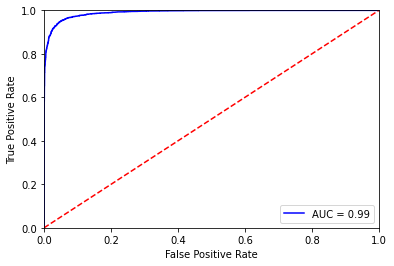

In [27]:
# Compute predicted probabilities on the validation set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [28]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [29]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

no-negative tweets ratio  0.557485336825921


AUC: 0.9917
Accuracy: 95.55%
Precision: 95.83%
Recall: 96.18%


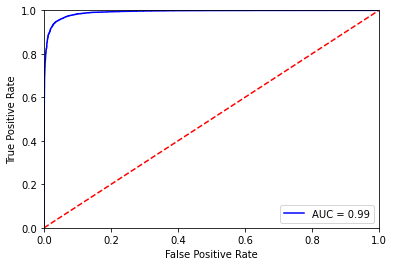

In [30]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)

Dataset 1

In [ ]:
X = df1.text.values
y = df1.sentiment.values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

In [ ]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)

Dataset 2

In [ ]:
X = df2.text.values
y = df2.sentiment.values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

In [ ]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)

Dataset 3

In [ ]:
X = df3.text.values
y = df3.sentiment.values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

In [ ]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)

Dataset 4

In [ ]:
X = df4.text.values
y = df4.sentiment.values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

In [ ]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)

Dataset 5

In [ ]:
X = df5.text.values
y = df5.sentiment.values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.1, random_state = 42)

In [ ]:
# Specify `MAX_LEN`
MAX_LEN =  280

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]], version="base", text_preprocessing_fn=text_preprocessing)[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, version="base", text_preprocessing_fn=text_preprocessing)
val_inputs, val_masks = preprocessing_for_bert(X_val, version="base", text_preprocessing_fn=text_preprocessing)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
set_seed(42) 
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, version="base")
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

In [ ]:
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("no-negative tweets ratio ", preds.sum()/len(preds))

In [ ]:
# Evaluate the Bert classifier for unseen test data
evaluate_roc(probs, y_test)